### Import the required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import gray2rgb

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.preprocessing.image import load_img, img_to_array

### Import | View | Pre-Processing DATASET

In [2]:
# Data Augmentation 
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=30,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [3]:
# Dataset Training
train_dataset  = train_datagen.flow_from_directory(directory = 'D:/NU spring 23.24/BMD404 Medical Image Informatics-2024SPRG-LECT-01/project/project dataset/Alzheimer_s Dataset/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 128)

Found 4098 images belonging to 4 classes.


In [4]:
# Data Validation
valid_dataset = valid_datagen.flow_from_directory(directory = 'D:/NU spring 23.24/BMD404 Medical Image Informatics-2024SPRG-LECT-01/project/project dataset/Alzheimer_s Dataset/train',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 128)

Found 1023 images belonging to 4 classes.


100%|██████████| 5/5 [00:12<00:00,  2.52s/it]


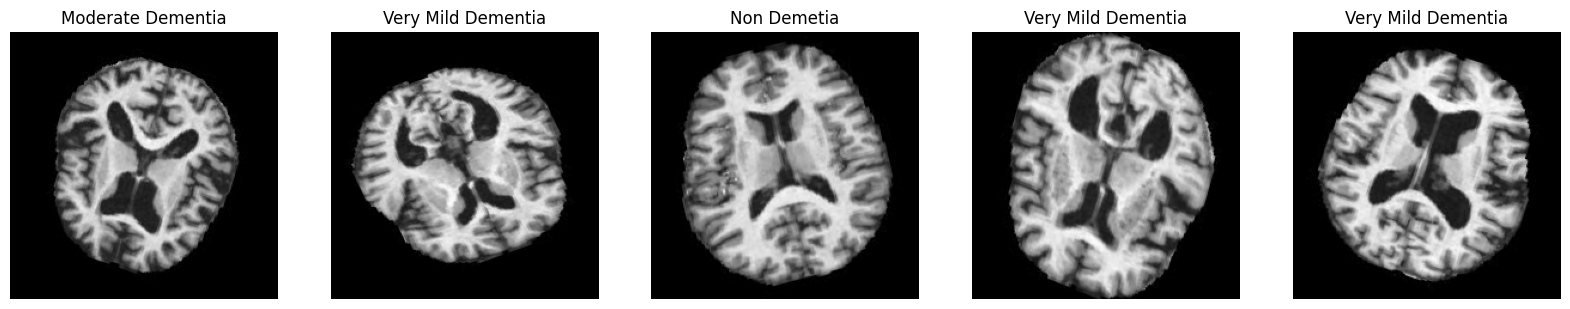

In [5]:
# Images views from different classes 
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize=(20,20))

for i in tqdm(range(0,5)):
    rand1 = np.random.randint(len(train_dataset))
    rand2 = np.random.randint(100)
    ax[i].imshow(train_dataset[rand1][0][rand2])
    ax[i].axis('off')
    a = train_dataset[rand1][1][rand2]
    if a[0] == 1:
        ax[i].set_title('Mild Dementia')
    elif a[1] == 1:
        ax[i].set_title('Moderate Dementia')
    elif a[2] == 1:
        ax[i].set_title('Non Demetia')
    elif a[3] == 1:
        ax[i].set_title('Very Mild Dementia')

### Build the Model

In [6]:
# Model Initialization

base_model = DenseNet169(input_shape=(224,224,3), 
                         include_top=False,
                         weights="imagenet")

51877672/51877672 [==============================] - 31s 1us/step


In [7]:
# Freezing Layers

for layer in base_model.layers:
    layer.trainable=False

In [8]:
# Building Model and adjust the required parameters

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))

In [9]:
# Model Summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 dropout (Dropout)           (None, 7, 7, 1664)        0         
                                                                 
 flatten (Flatten)           (None, 81536)             0         
                                                                 
 batch_normalization (BatchN  (None, 81536)            326144    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2048)              166987776 
                                                                 
 batch_normalization_1 (Batc  (None, 2048)             8192      
 hNormalization)                                        

In [10]:
# Model Compile 

OPT    = tensorflow.keras.optimizers.Adam(lr=0.001)

model.compile(loss='categorical_crossentropy',
              metrics=[tensorflow.keras.metrics.AUC(name = 'auc')],
              optimizer=OPT)

In [11]:
# Defining Callbacks

filepath = './best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [17]:
# Training the model using number of epochs
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 15,   
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/15
33/33 [==============================] - ETA: 0s - loss: 0.8429 - auc: 0.8801
Epoch 1: val_auc did not improve from 0.80495
33/33 [==============================] - 289s 9s/step - loss: 0.8429 - auc: 0.8801 - val_loss: 1.4982 - val_auc: 0.7481
Epoch 2/15
33/33 [==============================] - ETA: 0s - loss: 0.8083 - auc: 0.8876
Epoch 2: val_auc did not improve from 0.80495
33/33 [==============================] - 259s 8s/step - loss: 0.8083 - auc: 0.8876 - val_loss: 1.2813 - val_auc: 0.7777
Epoch 3/15
33/33 [==============================] - ETA: 0s - loss: 0.7645 - auc: 0.8977
Epoch 3: val_auc did not improve from 0.80495
33/33 [==============================] - 252s 8s/step - loss: 0.7645 - auc: 0.8977 - val_loss: 1.3086 - val_auc: 0.7983
Epoch 4/15
33/33 [==============================] - ETA: 0s - loss: 0.7435 - auc: 0.9036
Epoch 4: val_auc improved from 0.80495 to 0.81381, saving model to .\best_weights.hdf5
33/33 [==============================] - 245s 7s/step - los

### MODEL EVALUATION

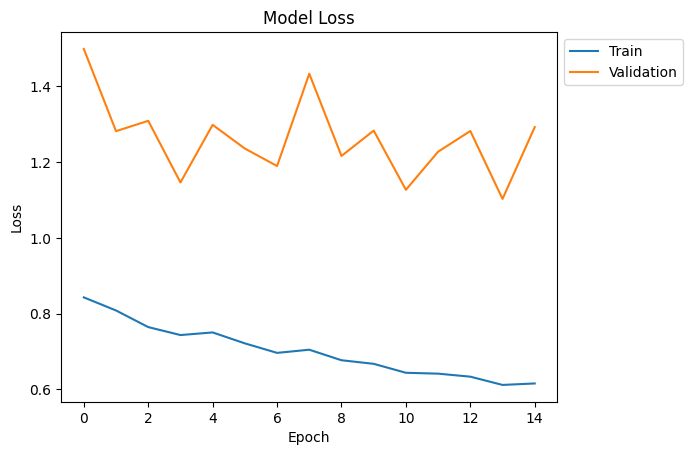

In [18]:
# Summarize history for loss function

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

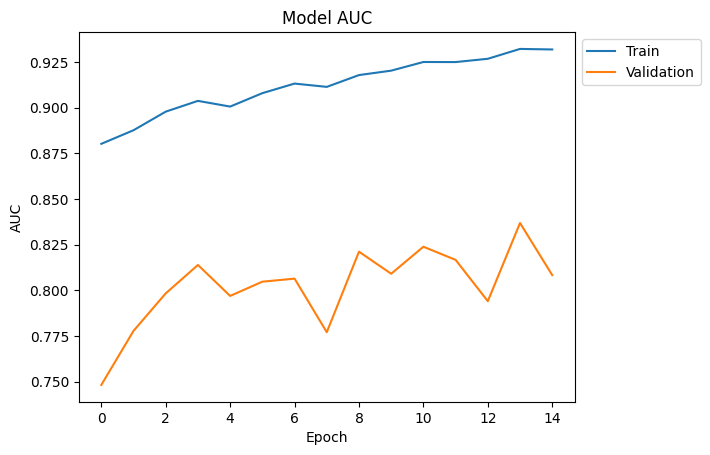

In [19]:
# Summarize history for loss and value accuracy

plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [20]:
# Test Model using the Test Dataset

test_dataset  = test_datagen.flow_from_directory(directory = 'D:/NU spring 23.24/BMD404 Medical Image Informatics-2024SPRG-LECT-01/project/project dataset/Alzheimer_s Dataset/train',
                                                 target_size = (224,224),
                                                 class_mode = 'categorical',
                                                 batch_size = 128)

Found 5121 images belonging to 4 classes.


In [21]:
# Evaluating Loss and AUC

model.evaluate(test_dataset)

41/41 [==============================] - 204s 5s/step - loss: 0.6761 - auc: 0.9238


[0.6761207580566406, 0.9237813353538513]

1/1 [==============================] - 0s 135ms/step
81.34% chances are there that the image is NonDemented


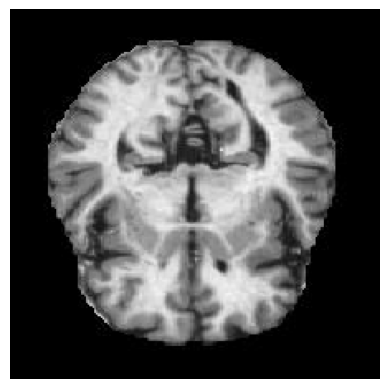

In [33]:
# Test Case No.1: Non-Dementia


# Assuming the model is already loaded as 'model' and test_dataset is defined

dic = test_dataset.class_indices
idc = {v: k for k, v in dic.items()}

img_path = 'D:/NU spring 23.24/BMD404 Medical Image Informatics-2024SPRG-LECT-01/project/project dataset/Alzheimer_s Dataset/train/NonDemented/nonDem30.jpg'
img = load_img(img_path, target_size=(224, 224))
img = img_to_array(img)
img = img / 255.0
plt.imshow(img)
plt.axis('off')
img = np.expand_dims(img, axis=0)

# Get prediction probabilities
prediction = model.predict(img)
answer = np.argmax(prediction, axis=1)[0]
probability = round(np.max(prediction) * 100, 2)

print(f"{probability}% chances are there that the image is {idc[answer]}")


1/1 [==============================] - 0s 152ms/step
67.83% chances are there that the image is MildDemented


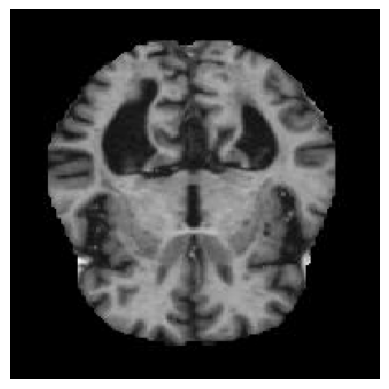

In [34]:
# Test Case 2: Mild Demented


dic = test_dataset.class_indices
idc = {v: k for k, v in dic.items()}

img_path = 'D:/NU spring 23.24/BMD404 Medical Image Informatics-2024SPRG-LECT-01/project/project dataset/Alzheimer_s Dataset/train\MildDemented/mildDem17.jpg'
img = load_img(img_path, target_size=(224, 224))
img = img_to_array(img)
img = img / 255.0
plt.imshow(img)
plt.axis('off')
img = np.expand_dims(img, axis=0)

# Get prediction probabilities
prediction = model.predict(img)
answer = np.argmax(prediction, axis=1)[0]
probability = round(np.max(prediction) * 100, 2)

print(f"{probability}% chances are there that the image is {idc[answer]}")


1/1 [==============================] - 0s 144ms/step
95.5% chances are there that the image is ModerateDemented


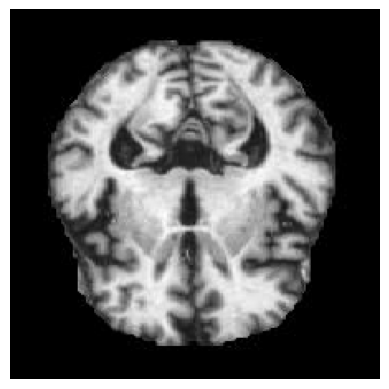

In [35]:
# Test Case 3: Moderate Demented

dic = test_dataset.class_indices
idc = {v: k for k, v in dic.items()}

img_path = 'D:/NU spring 23.24/BMD404 Medical Image Informatics-2024SPRG-LECT-01/project/project dataset/Alzheimer_s Dataset/train/ModerateDemented/moderateDem5.jpg'
img = load_img(img_path, target_size=(224, 224))
img = img_to_array(img)
img = img / 255.0
plt.imshow(img)
plt.axis('off')
img = np.expand_dims(img, axis=0)

# Get prediction probabilities
prediction = model.predict(img)
answer = np.argmax(prediction, axis=1)[0]
probability = round(np.max(prediction) * 100, 2)

print(f"{probability}% chances are there that the image is {idc[answer]}")

1/1 [==============================] - 0s 133ms/step
64.46% chances are there that the image is VeryMildDemented


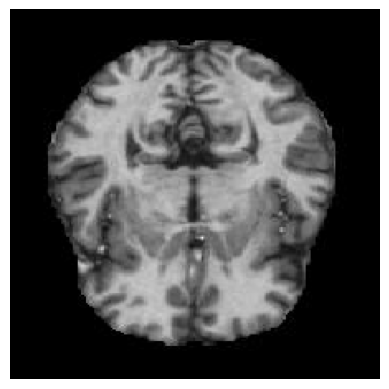

In [36]:
# Test Case 4: Very Mild Demented

dic = test_dataset.class_indices
idc = {v: k for k, v in dic.items()}

img_path = 'D:/NU spring 23.24/BMD404 Medical Image Informatics-2024SPRG-LECT-01/project/project dataset/Alzheimer_s Dataset/train/VeryMildDemented/verymildDem2.jpg'
img = load_img(img_path, target_size=(224, 224))
img = img_to_array(img)
img = img / 255.0
plt.imshow(img)
plt.axis('off')
img = np.expand_dims(img, axis=0)

# Get prediction probabilities
prediction = model.predict(img)
answer = np.argmax(prediction, axis=1)[0]
probability = round(np.max(prediction) * 100, 2)

print(f"{probability}% chances are there that the image is {idc[answer]}")